## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import dot
from numpy.linalg import norm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

plt.style.use('fivethirtyeight')

## Load Datasets

In [2]:
streaming1 = pd.read_json('../data/StreamingHistory0.json')
streaming2 = pd.read_json('../data/StreamingHistory1.json')
streaming3 = pd.read_json('../data/StreamingHistory2.json')
streaming4 = pd.read_json('../data/StreamingHistory3.json')
data_df = pd.read_csv('../data/spotify_songs_1922/cleaned_data.csv')

In [3]:
#show first 5 rows of data
data_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,main_artist,feat_artist
0,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,Dennis Day,[]
1,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[]
2,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,Frank Parker,[]
3,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,Phil Regan,[]
4,0.1960,1921,0.579,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.697,395076,0.346,0,4pyw9DVHGStUre4J6hPngr,0.168000,...,0.130,-12.506,1,Gati Mardika,6,1921,0.0700,119.824,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[]


In [4]:
#show information of data_df
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155098 entries, 0 to 155097
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           155098 non-null  float64
 1   year              155098 non-null  int64  
 2   acousticness      155098 non-null  float64
 3   artists           155098 non-null  object 
 4   danceability      155098 non-null  float64
 5   duration_ms       155098 non-null  int64  
 6   energy            155098 non-null  float64
 7   explicit          155098 non-null  int64  
 8   id                155098 non-null  object 
 9   instrumentalness  155098 non-null  float64
 10  key               155098 non-null  int64  
 11  liveness          155098 non-null  float64
 12  loudness          155098 non-null  float64
 13  mode              155098 non-null  int64  
 14  name              155098 non-null  object 
 15  popularity        155098 non-null  int64  
 16  release_date      15

## Cleaning and Transforming Dataset

In [5]:
#combine streaming dataset together
streaming = pd.concat([streaming1,streaming2,streaming3,streaming4],axis = 0)
streaming.reset_index(drop = True, inplace = True)

In [6]:
streaming.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33078 entries, 0 to 33077
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     33078 non-null  object
 1   artistName  33078 non-null  object
 2   trackName   33078 non-null  object
 3   msPlayed    33078 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [7]:
#check for duplicates
streaming.duplicated().sum()

0

In [8]:
#further check for duplicates
streaming[streaming.artistName == 'Drake']

,endTime,artistName,trackName,msPlayed
760,2020-06-02 04:46,Drake,Desires (with Future),84799
765,2020-06-02 11:33,Drake,Grammys,220426
872,2020-06-03 11:32,Drake,Teenage Fever,219692
910,2020-06-04 04:51,Drake,Toosie Slide,247058
1016,2020-06-06 11:15,Drake,Toosie Slide,247058
...,...,...,...,...
32594,2021-05-15 05:44,Drake,Light Up,274146
32629,2021-05-17 00:57,Drake,Wants and Needs (feat. Lil Baby),192956
33003,2021-05-22 08:54,Drake,What’s Next,178153
33010,2021-05-22 09:16,Drake,Wants and Needs (feat. Lil Baby),192956


It appears that the duplicates are for separate sessions where the same songs from an artist was played. 

In [9]:
streaming.sort_values('msPlayed',ascending = False).head()

,endTime,artistName,trackName,msPlayed
32037,2021-05-04 19:57,The Joe Rogan Experience,JRE MMA Show #107 with Georges St-Pierre,9617249
32272,2021-05-10 00:55,The Joe Rogan Experience,#1647 - Dave Chappelle,8610938
19089,2020-12-07 05:27,The Joe Rogan Experience,#1573 - Matthew Yglesias,6971794
32218,2021-05-09 09:57,The Joe Rogan Experience,#1647 - Dave Chappelle,6957604
22394,2021-01-08 16:07,The Joe Rogan Experience,#1580 - Andrew Schulz,6034848


The streaming datasets have podcasts in it. It doesnt matter, as the dataset for recommendations would have been cleaned for podcast episodes. The streaming dataset will be merged with the recommendations dataset based on track name and artist. However will sum the listening times for tracks that had multiple listening sessions. 

In [10]:
streaming.artistName.value_counts()

Kanye West                      807
Drake                           657
Future                          656
Playboi Carti                   602
Lil Uzi Vert                    550
                               ... 
Bobby "Blue" Bland                1
LisaMadeIt                        1
S. Fidelity                       1
Lil Jon & The East Side Boyz      1
Emeli Sandé                       1
Name: artistName, Length: 2450, dtype: int64

In [11]:
#set new df as the new streaming df 
streaming_df = streaming.groupby(['artistName','trackName']).sum().reset_index()

In [12]:
streaming_df.shape

(8749, 3)

In [13]:
#show first  rows of 
streaming_df.head()

,artistName,trackName,msPlayed
0,The No Good Podcast,2 Chainz - Money Maker Lil Wayne,91135
1,$NOT,BERETTA (feat. Wifisfuneral),160731
2,$NOT,GOSHA,24175
3,$NOT,Human (feat. Night Lovell),224221
4,$NOT,Moon & Stars (feat. Maggie Lindemann),187586


In [14]:
data_df.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo', 'main_artist', 'feat_artist'],
      dtype='object')

In [15]:
#change streaming_df column to concat
streaming_df.rename(columns={'trackName':'name','artistName':'main_artist'},inplace=True) 

In [16]:
#combined datasets on the name and main artist columns
combined_df = pd.merge(data_df,streaming_df, how = 'left', on =['name','main_artist'])

In [17]:
combined_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,loudness,mode,name,popularity,release_date,speechiness,tempo,main_artist,feat_artist,msPlayed
0,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,Dennis Day,[],NaN
1,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,-14.850,1,Gati Bali,5,1921,0.0339,110.339,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[],NaN
2,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,-9.316,1,Danny Boy,3,1921,0.0354,100.109,Frank Parker,[],NaN
3,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,Phil Regan,[],NaN
4,0.1960,1921,0.579,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.697,395076,0.346,0,4pyw9DVHGStUre4J6hPngr,0.168000,...,-12.506,1,Gati Mardika,6,1921,0.0700,119.824,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[],NaN


In [18]:
combined_df.shape[0] - data_df.shape[0]

0

In [19]:
#check if merge was done correctly
combined_df[(combined_df.main_artist == 'Drake') & (combined_df.name == 'Toosie Slide')]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,loudness,mode,name,popularity,release_date,speechiness,tempo,main_artist,feat_artist,msPlayed
35840,0.837,2020,0.321,['Drake'],0.834,247059,0.454,1,127QTOFJsJQp5LbJbu3A1y,0.000006,...,-9.75,0,Toosie Slide,84,2020-04-03,0.201,81.618,Drake,[],11280146.0


In [20]:
streaming_df.shape[0]

8749

In [21]:
combined_df[combined_df.msPlayed >= 0].shape[0]

3909

Out of 8749 songs that I have streamed, only 3909 I have listened to in the dataset

Moving forward, I will determine the number of times I have listened to the respective songs in the dataset

In [22]:
#set random seed
np.random.seed(42)

In [23]:
#make new column based on the division of song duaration and duration ms played
combined_df['times_played'] = np.round(combined_df['msPlayed']/combined_df['duration_ms'])

In [24]:
combined_df[(combined_df.main_artist == 'Drake') & (combined_df.name == 'Toosie Slide')]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,mode,name,popularity,release_date,speechiness,tempo,main_artist,feat_artist,msPlayed,times_played
35840,0.837,2020,0.321,['Drake'],0.834,247059,0.454,1,127QTOFJsJQp5LbJbu3A1y,0.000006,...,0,Toosie Slide,84,2020-04-03,0.201,81.618,Drake,[],11280146.0,46.0


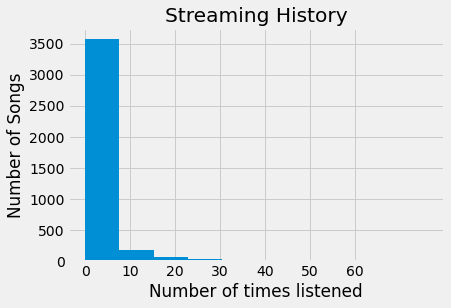

In [25]:
#deciding how many listens is considered a favourite
plt.ylabel('Number of Songs')
plt.xlabel('Number of times listened')
plt.title('Streaming History')
plt.hist(combined_df.times_played)
plt.xticks(np.arange(0,70,10), np.arange(0,70,10))
plt.savefig('../images/streaming-history', bbox_inches='tight');

Based on the histogram, I can conclude that 10 is the number of times listened to a song to be considered a 'favourite'. songs with 10 listens and greater will be labelled with a 1, and the others will be labelled with a 0.

In [26]:
combined_df['favourite'] = combined_df['times_played'].apply(lambda x: 1 if x >= 10 else 0)

In [27]:
combined_df['favourite'].value_counts()

0    154836
1       262
Name: favourite, dtype: int64

Even though the classes are hugely imbalance, the songs that we should keep as our train set are the ones that have been listened too. Therefore the 3909 songs, will be separated into a training set, and the other songs that I have not listened to will be the test set for songs to predict potential songs I would enjoy. 

In [28]:
train_idx = combined_df[combined_df['times_played'] >= 0].index

In [29]:
train_df = combined_df.loc[train_idx]

In [30]:
train_df.reset_index(drop = True, inplace=True)

In [31]:
train_df.favourite.value_counts()

0    3647
1     262
Name: favourite, dtype: int64

In [32]:
test_idx = combined_df[combined_df['times_played'].isna()].index

In [33]:
test_df = combined_df.loc[test_idx]

In [34]:
test_df.reset_index(drop = True, inplace=True)

In [35]:
test_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,name,popularity,release_date,speechiness,tempo,main_artist,feat_artist,msPlayed,times_played,favourite
0,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,Clancy Lowered the Boom,5,1921,0.4150,60.936,Dennis Day,[],NaN,NaN,0
1,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,Gati Bali,5,1921,0.0339,110.339,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[],NaN,NaN,0
2,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,Danny Boy,3,1921,0.0354,100.109,Frank Parker,[],NaN,NaN,0
3,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,Phil Regan,[],NaN,NaN,0
4,0.1960,1921,0.579,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.697,395076,0.346,0,4pyw9DVHGStUre4J6hPngr,0.168000,...,Gati Mardika,6,1921,0.0700,119.824,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[],NaN,NaN,0


## Modelling

In this section, we will use three classifier models, MNB, Logreg and Random Forest, to predict for any songs in the test set that i might like. 

This would give the recommender not only higher accuracy in predictions, but also a level of personalisation.

### SMOTE

In [36]:
train_df.favourite.value_counts(normalize=True)

0    0.932975
1    0.067025
Name: favourite, dtype: float64

Our dataset is highly imbalanced, with apporcximately 7% of the dataset being target. If our model were to classify every song as not a favourite, we would have an accuracy of 93%. This is not what we want. Therefore we will use SMOTE, Synthetic Minority Over-Sampling Technique, by joining the points of the minority class with line segments and then places artificial points on these lines.


In [37]:
#make a list of audio features in data_df
audio_features = ['tempo','speechiness','mode','loudness','liveness','key','instrumentalness','energy','danceability','acousticness','valence']

In [38]:
#make scaling function
def scaler(data):
    ss = StandardScaler()
    return ss.fit_transform(data)

In [39]:
#set X for train test split and oversampling
X = train_df[audio_features]
X_scaled = scaler(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)

In [40]:
X_scaled.head()

,tempo,speechiness,mode,loudness,liveness,key,instrumentalness,energy,danceability,acousticness,valence
0,0.190639,-0.860334,0.874520,-1.214295,-0.070587,1.009255,-0.237591,-1.780034,-0.602423,0.756612,0.187251
1,0.256962,-0.880715,0.874520,-1.524060,-0.542493,-1.181294,-0.237530,-2.107843,-0.553334,1.050842,0.285879
2,-1.753513,-0.865618,0.874520,-1.160461,-0.167554,0.187799,-0.237591,-1.602240,-0.620831,2.726674,-0.134362
3,-1.226909,-0.722951,0.874520,-0.519163,-0.594855,1.283074,-0.237529,-0.791052,0.483673,2.547578,1.186395
4,-1.123280,-0.961484,-1.143484,-0.587999,0.272030,-0.907475,-0.237581,-1.896712,-1.559660,2.658447,-0.524585


In [41]:
#set y target as dataframe
y = train_df.favourite

In [42]:
# Define SMOTE model and specify minority class for oversample
smote = SMOTE(sampling_strategy='minority', k_neighbors=4, random_state=42)
# Fit data
X_smote, y_smote = smote.fit_resample(X_scaled, y)


In [43]:
 # setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.25, random_state=42)


#### Random Forest Classifier

In [44]:
rf = RandomForestClassifier(n_estimators=100)


rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [None, 1, 2, 3],
}

# Instantiate GridSearchCV.
rf_gs = GridSearchCV(rf,
                     param_grid=rf_params,
                     cv=5)

rf_gs.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 1, 2, 3],
                         'n_estimators': [100, 150]})

In [45]:
rf_gs.best_estimator_

RandomForestClassifier(n_estimators=150)

In [46]:
rf_gs.score(X_train,y_train)

1.0

In [47]:
rf_gs.score(X_test, y_test)

0.9336622807017544

In [48]:
rf_y_pred = rf_gs.predict(X_test)

In [49]:
confusion_matrix(y_test, rf_y_pred)

array([[844,  81],
       [ 40, 859]])

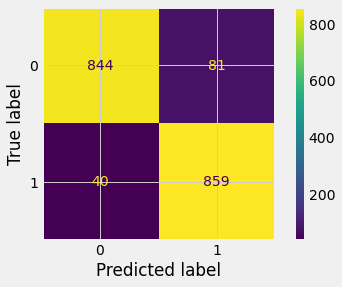

In [50]:
plot_confusion_matrix(rf_gs,X_test, y_test);

In [101]:
print(f'recall rate for random forest: {859/(859+81)}')

recall rate for random forest: 0.9138297872340425


### Gradient Boosting

In [53]:
gboost = GradientBoostingClassifier()
gboost_params = {
    'max_depth': [2,3,4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [.08, .1, .12]
}

gb_gs = GridSearchCV(gboost,
                     param_grid=gboost_params, 
                     cv=5)

gb_gs.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.08, 0.1, 0.12],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [100, 125, 150]})

In [54]:
gb_gs.score(X_train,y_train)

0.9729433272394881

In [55]:
gb_gs.score(X_test,y_test)

0.90625

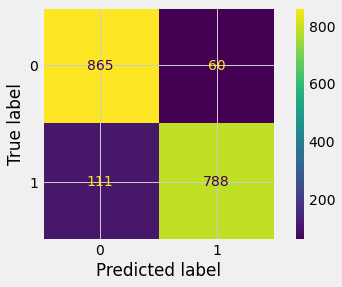

In [56]:
plot_confusion_matrix(gb_gs,X_test, y_test);

In [102]:
print(f'recall rate for Gradient boosting: {788/(788+60)}')

recall rate for Gradient boosting: 0.9292452830188679


### XGBoost

In [58]:
# fit model no training data
xgc = XGBClassifier()

xgc.fit(X_train, y_train)

[14:37:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/AdelAlsagoff/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [59]:
xgc.score(X_train,y_train)

/Users/AdelAlsagoff/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


1.0

In [60]:
xgc.score(X_test,y_test)

/Users/AdelAlsagoff/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.9457236842105263

/Users/AdelAlsagoff/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


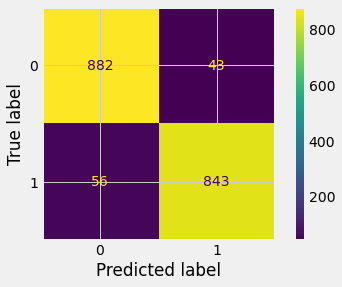

In [61]:
plot_confusion_matrix(xgc,X_test, y_test);

In [103]:
print(f'recall rate for XG boost: {843/(843+43)}')

recall rate for XG boost: 0.9514672686230248


### Labelling songs in test_df

In [63]:
test_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,name,popularity,release_date,speechiness,tempo,main_artist,feat_artist,msPlayed,times_played,favourite
0,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,Clancy Lowered the Boom,5,1921,0.4150,60.936,Dennis Day,[],NaN,NaN,0
1,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,Gati Bali,5,1921,0.0339,110.339,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[],NaN,NaN,0
2,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,Danny Boy,3,1921,0.0354,100.109,Frank Parker,[],NaN,NaN,0
3,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,Phil Regan,[],NaN,NaN,0
4,0.1960,1921,0.579,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.697,395076,0.346,0,4pyw9DVHGStUre4J6hPngr,0.168000,...,Gati Mardika,6,1921,0.0700,119.824,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[],NaN,NaN,0


In [64]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151189 entries, 0 to 151188
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           151189 non-null  float64
 1   year              151189 non-null  int64  
 2   acousticness      151189 non-null  float64
 3   artists           151189 non-null  object 
 4   danceability      151189 non-null  float64
 5   duration_ms       151189 non-null  int64  
 6   energy            151189 non-null  float64
 7   explicit          151189 non-null  int64  
 8   id                151189 non-null  object 
 9   instrumentalness  151189 non-null  float64
 10  key               151189 non-null  int64  
 11  liveness          151189 non-null  float64
 12  loudness          151189 non-null  float64
 13  mode              151189 non-null  int64  
 14  name              151189 non-null  object 
 15  popularity        151189 non-null  int64  
 16  release_date      15

In [89]:
#create new dataset for predictions and recommendation, dataset is songs never heard before
recommendation_df = test_df[audio_features]


In [98]:
#label potential favourites
personal_recommendations = xgc.predict(recommendation_df)


/Users/AdelAlsagoff/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [104]:
recommendation_df['favourite'] = personal_recommendations

<ipython-input-104-51d59ff7da2e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendation_df['favourite'] = personal_recommendations


In [105]:
recommendation_df.head()

,tempo,speechiness,mode,loudness,liveness,key,instrumentalness,energy,danceability,acousticness,valence,favourite
0,60.936,0.4150,1,-12.441,0.160,7,0.000000,0.341,0.819,0.732,0.9630,0
1,110.339,0.0339,1,-14.850,0.101,3,0.913000,0.166,0.328,0.961,0.0394,0
2,100.109,0.0354,1,-9.316,0.381,5,0.000028,0.309,0.275,0.967,0.1650,0
3,101.665,0.0380,1,-10.096,0.229,3,0.000002,0.193,0.418,0.957,0.2530,0
4,119.824,0.0700,1,-12.506,0.130,2,0.168000,0.346,0.697,0.579,0.1960,0


In [106]:
#concat recommendation audio features with respective names
recommendation_df = pd.concat([recommendation_df,test_df[['artists','name','main_artist','feat_artist','explicit','id','popularity','year','duration_ms']]],axis=1)


In [107]:
recommendation_df.head()

,tempo,speechiness,mode,loudness,liveness,key,instrumentalness,energy,danceability,acousticness,...,favourite,artists,name,main_artist,feat_artist,explicit,id,popularity,year,duration_ms
0,60.936,0.4150,1,-12.441,0.160,7,0.000000,0.341,0.819,0.732,...,0,['Dennis Day'],Clancy Lowered the Boom,Dennis Day,[],0,7xPhfUan2yNtyFG0cUWkt8,5,1921,180533
1,110.339,0.0339,1,-14.850,0.101,3,0.913000,0.166,0.328,0.961,...,0,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,Gati Bali,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[],0,1o6I8BglA6ylDMrIELygv1,5,1921,500062
2,100.109,0.0354,1,-9.316,0.381,5,0.000028,0.309,0.275,0.967,...,0,['Frank Parker'],Danny Boy,Frank Parker,[],0,3ftBPsC5vPBKxYSee08FDH,3,1921,210000
3,101.665,0.0380,1,-10.096,0.229,3,0.000002,0.193,0.418,0.957,...,0,['Phil Regan'],When Irish Eyes Are Smiling,Phil Regan,[],0,4d6HGyGT8e121BsdKmw9v6,2,1921,166693
4,119.824,0.0700,1,-12.506,0.130,2,0.168000,0.346,0.697,0.579,...,0,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,Gati Mardika,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[],0,4pyw9DVHGStUre4J6hPngr,6,1921,395076


In [108]:
best_recommendation_df = pd.concat([recommendation_df[recommendation_df.favourite == 1],train_df[train_df.favourite == 1]],axis=0)
best_recommendation_df.reset_index(inplace = True, drop = True)

In [109]:
best_recommendation_df.shape

(24531, 24)

In [110]:
recommendation_df[recommendation_df.favourite == 1]

,tempo,speechiness,mode,loudness,liveness,key,instrumentalness,energy,danceability,acousticness,...,favourite,artists,name,main_artist,feat_artist,explicit,id,popularity,year,duration_ms
5,66.221,0.0615,1,-10.589,0.1150,0,0.000000,0.203,0.518,0.9960,...,1,['John McCormack'],The Wearing of the Green,John McCormack,[],0,5uNZnElqOS3W4fRmRYPk4T,4,1921,159507
6,92.867,0.0456,0,-21.091,0.3630,1,0.527000,0.088,0.389,0.9930,...,1,['Sergei Rachmaninoff'],"Morceaux de fantaisie, Op. 3: No. 2, Prélude i...",Sergei Rachmaninoff,[],0,02GDntOXexBFUvSgaXLPkd,2,1921,218773
35,92.707,0.0522,0,-12.194,0.3810,0,0.000000,0.290,0.522,0.9920,...,1,['Maurice Chevalier'],Je N'peux Pas Vivre Sans Amour,Maurice Chevalier,[],0,1RgXfAX9PrSfTKTFvOQxPR,0,1921,170627
36,79.997,0.0575,1,-11.108,0.1780,1,0.034900,0.422,0.577,0.1850,...,1,['THE GUY'],Love for Guns,THE GUY,[],1,1T2NGVgAoXjQPEjxTGFRZV,0,1921,404062
38,107.840,0.0282,0,-9.843,0.0468,1,0.000004,0.537,0.689,0.2580,...,1,['Mehmet Kemiksiz'],Ey Bülbül-i Ter Zebân-i İrf,Mehmet Kemiksiz,[],0,1WOXWCjKZzJJRSMJcrLrK1,0,1921,145371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151162,76.474,0.1010,1,-6.520,0.1150,0,0.000018,0.304,0.840,0.0732,...,1,['KYLE'],What It Is,KYLE,[],1,1AYNmdKudx7JArl2uDy1nv,65,2020,143476
151164,111.453,0.0350,1,-10.282,0.2340,1,0.019000,0.320,0.328,0.3240,...,1,['Phoebe Bridgers'],I Know The End,Phoebe Bridgers,[],0,3cr3oAP4bQFNjZBV7ElKaB,66,2020,344693
151166,102.950,0.0315,1,-4.244,0.1420,0,0.000000,0.711,0.639,0.0242,...,1,"['Alesso', 'Charlotte Lawrence']",THE END,Alesso,['Charlotte Lawrence'],0,4w7vZjpsnpKizj7NE0Nuld,70,2020,206308
151172,172.044,0.0883,1,-4.727,0.0598,0,0.000828,0.629,0.788,0.1600,...,1,"['Rauw Alejandro', 'Dalex', 'Lenny Tavárez', '...","Elegí (feat. Farruko, Anuel AA, Sech, Dímelo F...",Rauw Alejandro,"['Dalex', 'Lenny Tavárez', 'Farruko', 'Anuel A...",1,3oCghu20Kto5Xcu8Pg0cit,75,2020,325692


In [111]:
best_recommendation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24531 entries, 0 to 24530
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo             24531 non-null  float64
 1   speechiness       24531 non-null  float64
 2   mode              24531 non-null  int64  
 3   loudness          24531 non-null  float64
 4   liveness          24531 non-null  float64
 5   key               24531 non-null  int64  
 6   instrumentalness  24531 non-null  float64
 7   energy            24531 non-null  float64
 8   danceability      24531 non-null  float64
 9   acousticness      24531 non-null  float64
 10  valence           24531 non-null  float64
 11  favourite         24531 non-null  int64  
 12  artists           24531 non-null  object 
 13  name              24531 non-null  object 
 14  main_artist       24530 non-null  object 
 15  feat_artist       24531 non-null  object 
 16  explicit          24531 non-null  int64 

## Putting the Personalised Recommender Togther

Using the best_recommendation_df, where it is a dataframew ith only predicted songs that I may like as well as songs that I actually do like, this would significantly improve the accuracy of the recommendation. 

In [112]:
#create dataframe only used to apply cosine similarity calculation on
# only take the numerical columns and drop the numerical ones that do not represent audio features
data_df_cosim = best_recommendation_df.select_dtypes(include=['int64','float64']).drop(columns=['msPlayed','year','popularity','explicit','times_played','duration_ms','favourite'])

#concat with id so that we can use the grouby function on it
data_df_cosim = pd.concat([data_df_cosim,best_recommendation_df.id], axis =1)

In [113]:
#this puts the dataset into a matrix and indexed by the id
song_sim_matrix = data_df_cosim.groupby('id').sum()

song_sim_matrix.head()

,tempo,speechiness,mode,loudness,liveness,key,instrumentalness,energy,danceability,acousticness,valence
id,,,,,,,,,,,
000GyYHG4uWmlXieKLij8u,89.926,0.5200,0,-5.922,0.0824,1,0.000000,0.898,0.797,0.469,0.1460
000x2qE0ZI3hodeVrnJK8A,134.248,0.0306,1,-14.240,0.1800,0,0.000000,0.356,0.507,0.339,0.4720
0024tEymsoc9FyKUauQngQ,82.453,0.0259,1,-18.255,0.1320,1,0.929000,0.234,0.305,0.752,0.0780
0046quUYhSAFccrKIC3Iht,144.435,0.0305,1,-9.959,0.1960,1,0.000006,0.435,0.480,0.207,0.3280
007SutdC0rVG2CSkuQMtJw,92.584,0.0365,1,-30.130,0.0926,1,0.960000,0.034,0.140,0.632,0.0363


In [114]:
#scale our dataframe
song_sim_matrix_scaled = scaler(song_sim_matrix)

#convert our numpy matrix into dataframe
song_sim_matrix_df = pd.DataFrame(song_sim_matrix_scaled, index=song_sim_matrix.index,columns=song_sim_matrix.columns)

In [115]:
#repeat same process above for other songs as best recommendations matrix may not have them

# only take the numerical columns and drop the numerical ones that do not represent audio features
all_data_df_cosim = data_df.select_dtypes(include=['int64','float64']).drop(columns=['year','popularity','explicit','duration_ms'])

#concat with id so that we can use the grouby function on it
all_data_df_cosim = pd.concat([all_data_df_cosim,data_df.id], axis =1)

In [116]:
#this puts the dataset into a matrix and indexed by the id
all_song_sim_matrix = all_data_df_cosim.groupby('id').sum()

#scale our dataframe
all_song_sim_matrix_scaled = scaler(all_song_sim_matrix)

#convert our numpy matrix into dataframe
all_song_sim_matrix_df = pd.DataFrame(all_song_sim_matrix_scaled, index=all_song_sim_matrix.index,columns=all_song_sim_matrix.columns)

In [117]:
all_song_sim_matrix_df.head()

,valence,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo
id,,,,,,,,,,,
000G1xMMuwxNHmwVsBdtj1,0.093255,-1.297802,-1.616679,1.540470,-0.526461,-0.910407,-0.711547,1.160521,0.643933,-0.180412,2.416146
000GyYHG4uWmlXieKLij8u,-1.467362,-0.084203,1.469889,1.551683,-0.526802,-1.194807,-0.709823,0.973435,-1.552956,2.508301,-0.879370
000Npgk5e2SgwGaIsN3ztv,-0.139502,1.276071,-1.496868,-1.262732,2.300917,-0.626006,-0.545525,-1.488629,0.643933,-0.097830,-1.343625
000ZxLGm7jDlWCHtcXSeBe,1.234146,0.783604,0.830895,0.000578,2.297700,-0.910407,-0.534036,0.219455,-1.552956,-0.401828,-0.626862
000jBcNljWTnyjB4YO7ojf,1.672950,0.413588,1.418541,1.215299,-0.526802,-0.057205,-0.298504,0.855758,0.643933,-0.367120,-0.127826


In [118]:
#getting the score 

def sim_score_generator(song,artist,number_of_recommedations):
    
    """takes in song and artist to return list of similar songs"""
    
    #takes artist and song name to find song id
    song_id = data_df[(data_df.main_artist == artist)&(data_df.name == song)]['id'].values[0]
    
    song_array = all_song_sim_matrix_df.loc[song_id].to_numpy()
    
    #tuple of sim score with song_index
    sim_score = []
    #counting the index
    song_index = -1
    
    #iterate through all songs in dataset
    for song in range(len(best_recommendation_df)):
        
        song_index += 1

        # convert in to array
        other_song_array = song_sim_matrix_df.iloc[song].to_numpy()
        # sim score calculation
        score = dot(song_array,other_song_array)/(norm(song_array)*norm(other_song_array))
        
        #get other song id
        other_song_id = song_sim_matrix_df.iloc[song].name
        
        # append to list
        song_score_and_id = (score,song_index, other_song_id)
    
        # assign the position index of the song with the score
        sim_score.append(song_score_and_id)
    
    
    #list of N recommendations based on highest sim score and corresponding index
    return(sorted(sim_score,reverse=True)[1:number_of_recommedations+1])

In [119]:
def show_recommendations(top_recomendations):
    #unpack tuples in list of recommendation
    for score,song_idx,other_song_id in top_recomendations:
        #find the id of the from the sim matrix 
        
        sim_song_id = song_sim_matrix_df.iloc[song_idx].name
        
        
        #print the corresponding artist and song to that matches the id from the data_df
        print(f"Artist: {data_df[data_df.id.str.match(sim_song_id)]['main_artist'].values[0]}")
        print(f"Song: {data_df[data_df.id.str.match(sim_song_id)]['name'].values[0]}")
        print(f"Year & Popularity: {data_df[data_df.id.str.match(sim_song_id)]['year'].values[0]}, {data_df[data_df.id.str.match(sim_song_id)]['popularity'].values[0]}\n") 


In [120]:
song = 'Ice Ice Baby'
artist = "Vanilla Ice"

#return 10 similar song with raw similiarity scores and assign into list 
recommendations = sim_score_generator(song,artist,10)

#print similar songs with corresponding artist and song name
show_recommendations(recommendations)

Artist: The Format
Song: On Your Porch
Year & Popularity: 2003, 43

Artist: The Supremes
Song: Stop! In The Name Of Love - Single Version
Year & Popularity: 1965, 64

Artist: Keith Jarrett
Song: The Rich (And The Poor)
Year & Popularity: 1974, 38

Artist: Buddy Holly
Song: (Ummm, Oh Yeah) Dearest - Overdubbed Version 2
Year & Popularity: 1964, 29

Artist: Los Enanitos Verdes
Song: Luz De Dia
Year & Popularity: 1999, 64

Artist: Les Paul & Mary Ford
Song: Goodnight Irene
Year & Popularity: 1958, 5

Artist: Breaking Benjamin
Song: Rain
Year & Popularity: 2004, 51

Artist: The Kinks
Song: Mr. Songbird - Stereo Mix; 2018 Remaster
Year & Popularity: 1968, 23

Artist: David Bowie
Song: Changes - 2015 Remaster
Year & Popularity: 1971, 65

Artist: Gregory Alan Isakov
Song: Evelyn
Year & Popularity: 2009, 44



In [121]:
song = 'All of Me'
artist = "John Legend"

#return 10 similar song with raw similiarity scores and assign into list 
recommendations = sim_score_generator(song,artist,10)

#print similar songs with corresponding artist and song name
show_recommendations(recommendations)

Artist: A Tribe Called Quest
Song: God Lives Through
Year & Popularity: 1993, 45

Artist: Brand Nubian
Song: Punks Jump Up to Get Beat Down
Year & Popularity: 1993, 38

Artist: Cypress Hill
Song: Siempre Peligroso (feat. Fermin IV Caballero)
Year & Popularity: 1999, 52

Artist: Khalid
Song: Location
Year & Popularity: 2017, 80

Artist: Slum Village
Song: Count The Ways
Year & Popularity: 2004, 41

Artist: Aesop Rock
Song: Commencement At the Obedience Academy
Year & Popularity: 2000, 35

Artist: Father MC
Song: Treat Them Like They Want To Be Treated
Year & Popularity: 1990, 30

Artist: Polo G
Song: Neva Cared
Year & Popularity: 2018, 69

Artist: Jodeci
Song: Ride & Slide
Year & Popularity: 1993, 33

Artist: Afroman
Song: Tumbleweed
Year & Popularity: 2001, 42



In [122]:
song = "Mr. Brightside"
artist = "The Killers"

#return 10 similar song with raw similiarity scores and assign into list 
recommendations = sim_score_generator(song,artist,10)

#print similar songs with corresponding artist and song name
show_recommendations(recommendations)

Artist: Makano
Song: Dejame Entrar
Year & Popularity: 2008, 58

Artist: LA INDIA
Song: Sedúceme - Salsa Version
Year & Popularity: 2002, 43

Artist: Los Ángeles Azules
Song: Mis Sentimientos
Year & Popularity: 2015, 58

Artist: El Gran Combo De Puerto Rico
Song: Compañera Mía
Year & Popularity: 1982, 42

Artist: Anuel AA
Song: Keii
Year & Popularity: 2020, 73

Artist: Eddie Money
Song: Maybe I'm a Fool
Year & Popularity: 1977, 27

Artist: Landon Cube
Song: Pretty
Year & Popularity: 2019, 64

Artist: Supertramp
Song: Breakfast In America - Remastered
Year & Popularity: 1979, 70

Artist: "Blackmores Night"
Song: Under A Violet Moon
Year & Popularity: 1999, 44

Artist: Amy Grant
Song: Everywhere I Go
Year & Popularity: 1985, 23

